## Как подступиться к кластеризации

Наиболее показательными графиками при работе с задачей кластеризации чаще всего будут **диаграммы рассеяния**

Построим диаграммы рассеяния для всех пар признаков в датасете iris https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-dataset при помощи `sns.pairplot` 

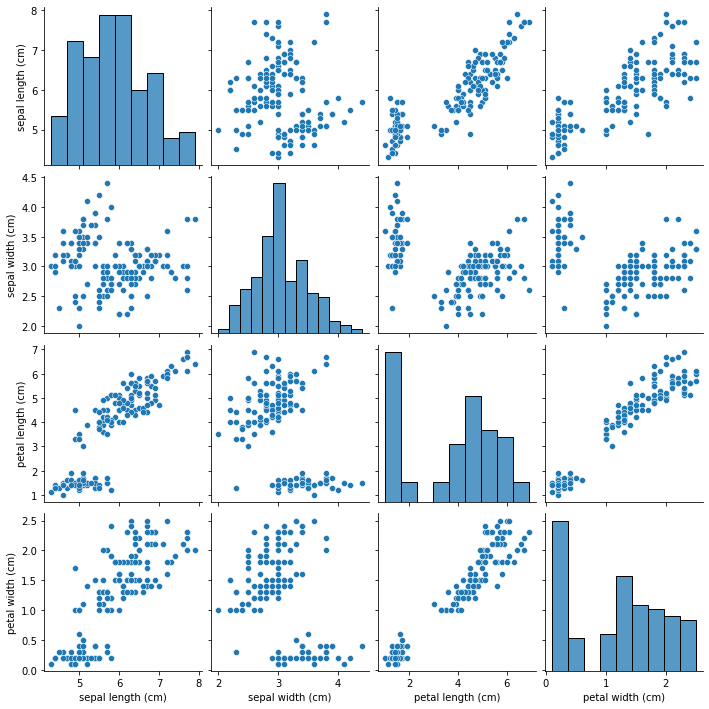

In [1]:
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

X, y = load_iris(return_X_y = True, as_frame = True)

sns.pairplot(X)
plt.show()

На большинстве графиков видно две-три группы точек

## Алгоритм K-means

Алгоритм применяется в задачи кластеризации - разделения объектов на непересекающиеся группы так, чтобы объекты одной группы были максимально похожи друг на друга.

Центроид вычисляется как среднее арифметическое векторов: $$c = \frac{1}{n}\sum_{i=1}^{n}x^i = \frac{1}{n} (\sum_{i=1}^{n}x_1^i, \sum_{i=1}^{n}x_2^i, \ldots, \sum_{i=1}^{n}x_n^i)$$

где n - количество векторов

Для определения кластера, необходимо найти расстояние от объекта до центроидов и выбрать тот, до которого расстояние минимально, это можно записать в виде формуле:
$$k_i = min_k \sqrt{(c_i - x_i)^2}$$


Во время итераций алгоритма наша цель - для каждого кластера минимизировать сумму расстояний от его центроида до всех элементов. **Целевая функция** примет вид:
$$J = \sum_{i = 1}^{K}\sum_{j = 1}^{d}(x_j^i - c_j^i)^2$$

Где K - кол-во кластеров, d - все расстояния внутри кластера

## Алгоритм K-means своими руками

[[5.006      3.428      1.462      0.246     ]
 [5.9016129  2.7483871  4.39354839 1.43387097]
 [6.85       3.07368421 5.74210526 2.07105263]]


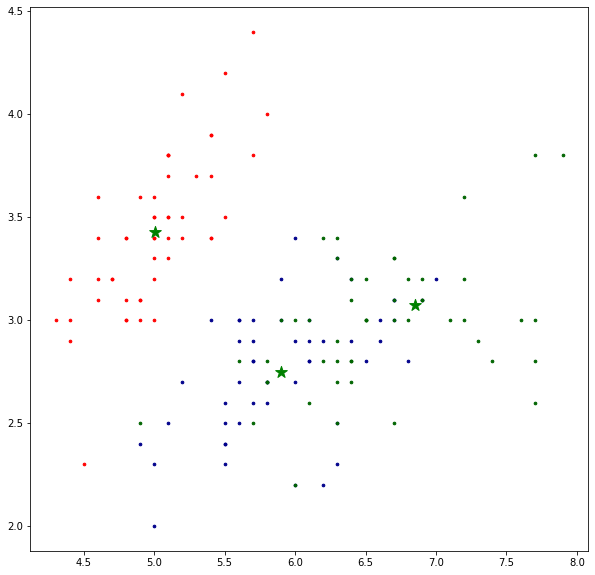

In [2]:
# Для работы с памятью
from copy import deepcopy
import numpy as np

# Перевод в numpy
X, y = X.to_numpy(), y.to_numpy()


# Число кластеров
K = 3
# Количество объектов в данных
n = X.shape[0]
# Количество признаков в данных
c = X.shape[1]

# Задаем случайные центроиды
mean = np.mean(X, axis = 0)
std = np.std(X, axis = 0)
centers = np.random.randn(K,c)*std + mean

centers_old = np.zeros(centers.shape) # Храним старые центроиды
centers_new = deepcopy(centers) # Храним новые центроиды

clusters = np.zeros(n)
distances = np.zeros((n,K))

error = np.linalg.norm(centers_new - centers_old)
max_iter = 300
cur_iter = 0
# Если кластеры не изменились или достигнуто максимальное кол-во итераций - прекращаем алгоритм
while (error != 0 or cur_iter > max_iter):
    # Рассчитываем расстояния до каждого центроида
    for i in range(K):
        distances[:,i] = np.linalg.norm(X - centers_new[i], axis=1)
    # Присваиваем объектам кластер ближайшего центроида
    clusters = np.argmin(distances, axis = 1)
    
    centers_old = deepcopy(centers_new)
    # Для каждого центроида считаем среднее расстояние до объектов и изменяем его
    for i in range(K):
        centers_new[i] = np.mean(X[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)
    cur_iter += 1
print(centers_new)

# Визуализация
colors=['red', '#00008b', '#006400']
plt.figure(figsize = (10, 10))
for i in range(n):
    plt.scatter(X[i, 0], X[i,1], s=7, color = colors[int(y[i])])
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)
plt.show()

Функция `np.linalg.norm` считает норму вектора или матрицы. Параметр `axis` задает ось (в случае двумерной матрицы строки или столбцы) - вдоль которой следует считать норму. При помощи этой функции посчитаем расстояние между векторами

In [6]:
a = np.array([2, 4])
b = np.array([5, 4])

print("Расстояние между векторами a и b:", np.linalg.norm(a-b))

Расстояние между векторами a и b: 3.0


Действительно: $d = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2} = \sqrt{(5 - 2)^2 + (4 - 4)^2} = \sqrt{3^2} = 3$

## Алгоритм K-means в sklearn

In [10]:
from sklearn.cluster import KMeans
import pandas as pd

km = KMeans(n_clusters = 3)

km.fit(X)

# Сумма расстояний от объектов до кластеров
km.inertia_

# Массив с кластером каждой точки
clusters = km.labels_

total_df = pd.DataFrame(X)
total_df['cluster'] = clusters

total_df.head(10)

,0,1,2,3,cluster
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1
5,5.4,3.9,1.7,0.4,1
6,4.6,3.4,1.4,0.3,1
7,5.0,3.4,1.5,0.2,1
8,4.4,2.9,1.4,0.2,1
9,4.9,3.1,1.5,0.1,1


In [13]:
total_df['cluster'].value_counts()

2    61
1    50
0    39
Name: cluster, dtype: int64

In [14]:
total_df.groupby('cluster', as_index = False).mean()

,cluster,0,1,2,3
0,0,6.853846,3.076923,5.715385,2.053846
1,1,5.006000,3.428000,1.462000,0.246000
2,2,5.883607,2.740984,4.388525,1.434426


## Подбор оптимального количества кластеров

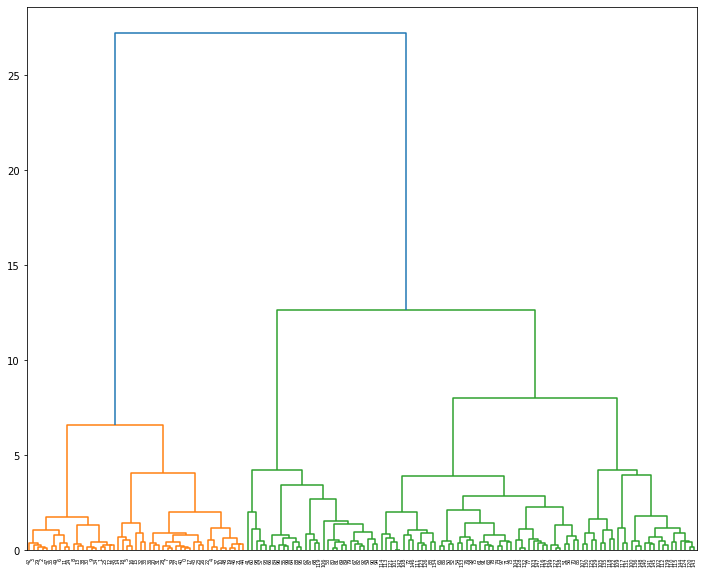

In [15]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

distance_matrix = linkage(X_sc, method = 'ward')

plt.figure(figsize = (12, 10))
dendogram_plt = dendrogram(distance_matrix, orientation = 'top')
plt.show()

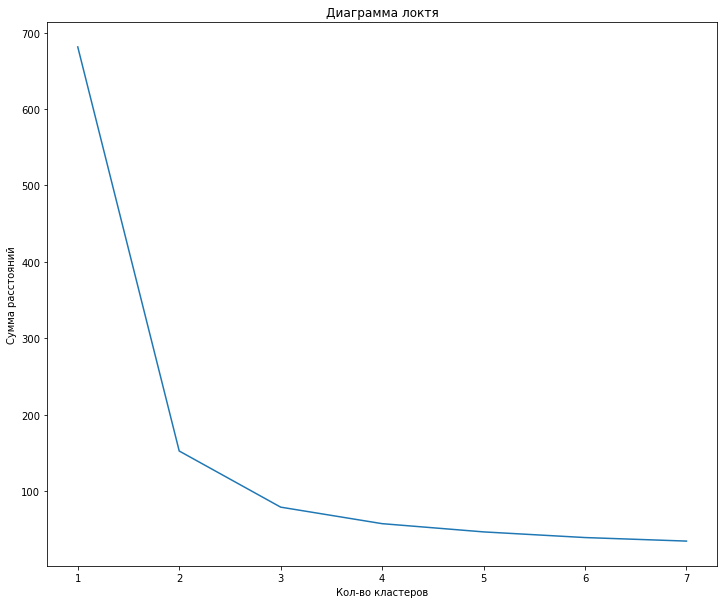

In [25]:
# Для хранения суммарного расстояния
error = []

for k in range(1, 8):
    k_means = KMeans(n_clusters = k, random_state = 42)
    k_means.fit(X)
    error.append(k_means.inertia_)
    
plt.figure(figsize=(12, 10))
plt.title('Диаграмма локтя')
plt.plot(range(1, 8), error)
plt.xlabel('Кол-во кластеров')
plt.ylabel('Сумма расстояний')
plt.show()
